In [1]:
import os
import time
import torch
from timm import models
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.optim import SGD, lr_scheduler
from tqdm import tqdm
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.metrics.pairwise import cosine_distances
import rasterio

/home/zack/anaconda3/envs/test/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_DIR='/home/zack/datasets/geological_similarity'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VAL_DIR = os.path.join(DATA_DIR, 'val')
BATCH_SIZE=512
NUM_WORKERS=4
NUM_EPOCHS=40
OUTPUT_DIR='./output'

# Model Selection

I'm currently limited on my GPU resources at the moment, and not to mention time. Given those two constraints, I'm going to forgo any exotic networks (sorry ConvNext/ViT) in favor of a classic resnet18. It's small enough for prototyping but still robust enough to be performant on small datasets.

Similar to the aircraft manufacturer identification task, we are going to initialize our model with pretrained weights- specifically Imagenet1k pretrained weights. However, this may not be the most robust initialization we could provide, especially if one of our downstream tasks is a kNN retrieval. See the last section of this notebook for more details.

In [3]:
model = models.resnet18(num_classes=6, pretrained=True)

# Construct the training dataset

Given the time constraints, I'm not going to go crazy with augmentations. However, I'll choose some augmentations that I think will lead to a robust model. On CIFAR, I found fewer augmentations often worked better for convergence, so I'll follow the same premise here. I'll ensure the data is resized correctly, occasionally grayscale the imagery, the apply random horizontal flips to increase virtual samples.

First, I'm going to create a custom dataset that will come in handy later. This dataset will return the filepath in addition to the image and target label.

In [35]:
class ImageFolderFilePath(ImageFolder):
    def __getitem__(self, index: int):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (sample, target, path) where target is class_index of the target class.
        """
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target, path

In [36]:
# Use the normalization statistics previously computed 
normalize = transforms.Normalize(mean=[0.5083, 0.5198, 0.5196],
                                     std=[0.1851, 0.1997, 0.2196])

train_dataset = ImageFolderFilePath(
        TRAIN_DIR,
        transforms.Compose([
            transforms.Resize(28),
            transforms.RandomGrayscale(p=0.2),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ]))
classes = sorted(os.listdir(TRAIN_DIR))

# Construct the validation dataset

Unlike the training dataset, we don't want random augmentations in our validation dataset. Given the randomness, we may make some looks easier than others at varying validation steps, which could effect our model selection. Instead, we simply ensure our imagery is resized to the correct size and normalize it relative to the training dataset statistics. Intuitively, we can't use the validation dataset statistics here as that would constitute data leakage.

In [37]:
val_dataset = ImageFolderFilePath(
        VAL_DIR,
        transforms.Compose([
            transforms.Resize(28),
            transforms.ToTensor(),
            normalize,
        ]))

# Construct the dataloaders

Here, we construct the dataloaders. Since the imagery is so small, we can use a large batch size and a number of workers sufficient to saturate the GPU (and likely CPU). Since we aren't doing any fance sampling techniquese (the dataset is balanced), we can simply shuffle the training dataset and sequentially sample the validation dataset.

In [38]:
train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=True,
        num_workers=NUM_WORKERS, pin_memory=True)

val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=NUM_WORKERS, pin_memory=True)

# Construct the Optimizer and Scheduler

Ideally, I'd perform a hyperparameter study to determine the optimal hyperparameters for this model. However, I suspect this dataset will be fairly easy for our model to learn. I'll use a bog-standard 0.1 learning rate, and a multi-step scheduler with a single step half way through training.

In [41]:
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[20], gamma=0.1)

# Construct the Loss function

Since my goal is to perform supervised classification and my data is not multi-target, I'm opting for a standard CrossEntropyLoss function. I'm not going to use any weighting or softening for this problem as its highly balanced.

In [9]:
criterion = torch.nn.CrossEntropyLoss().cuda()

# Define our training logic

The first thing I'm going to define is a object that tracks statistics and provides a method for averaging together across samples. We can update this object as we feed batches through the model and it will make loss tracking easier.

In [10]:
class AverageMeter(object):
    """Computes and stores the average and current value""" 
    def __init__(self):
        self.reset()
                   
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0 

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

### Define our training epoch loop

This method will handle a single epoch of training. It will iterate over the dataloader, perform the forward pass, compute the loss and optimize.

In [11]:
def train(train_loader, model, criterion, optimizer, epoch):
    losses = AverageMeter()

    # switch to train mode
    model.train()

    optimizer.zero_grad()
    for i, (images, target, path) in tqdm(enumerate(train_loader), desc=f'Train Epoch {epoch}:', total=len(train_loader)):
        images = images.cuda(non_blocking=True)
        target = target.cuda(non_blocking=True)

        # compute features
        feature = model(images)
        loss = criterion(feature, target)

        loss.backward()

        # record loss
        losses.update(loss.item(), images.size(0))

        # compute gradient and do SGD step
        optimizer.step()
        optimizer.zero_grad()
    print(f'Epoch {epoch} Train Loss {losses.avg:.4f}')

### Define our evaluation loop

This method will handle a single epoch of validation. It will compute the loss and accuracy and return it.

In [12]:
def evaluate(val_loader, model, criterion, epoch):
    accuracies = AverageMeter()
    losses = AverageMeter()
    # switch to train mode
    model.eval()

    for i, (images, target, path) in tqdm(enumerate(val_loader), desc=f'Validation Epoch {epoch}:', total=len(val_loader)):
        images = images.cuda(non_blocking=True)
        target = target.cuda(non_blocking=True)
        
        # compute features
        feature = model(images)
        loss = criterion(feature, target)

        # record loss
        losses.update(loss.item(), images.size(0))
        
        pred = feature.argmax(dim=1)
        correct_mask = pred == target
        accuracy = correct_mask.sum() / images.shape[0]
        accuracies.update(accuracy.item(), 1)
    return accuracies.avg, losses.avg

We want to make sure we save our model, so lets define a function that does that for us.

In [13]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar', output_dir='./output'):
    os.makedirs(output_dir, exist_ok=True)
    torch.save(state, os.path.join(output_dir, filename))
    if is_best:
        shutil.copyfile(os.path.join(output_dir, filename), os.path.join(output_dir, 'model_best.pth.tar'))

# Move model to GPU

Wrap the model in dataparallel and move it to the GPU.

In [14]:
model = torch.nn.DataParallel(model).cuda()

# Train the model

Train the model for NUM_EPOCHS, keeping track of the best model. We'll checkpoint both the most recent and the best model based on accuracy.

In [15]:
best_accuracy = 0.0
for epoch in range(NUM_EPOCHS):
    train(train_loader, model, criterion, optimizer, epoch)
    
    # evaluate on validation set
    accuracy, loss = evaluate(val_loader, model, criterion, epoch)
    
    print(f'Model achieved {(accuracy * 100):0.4f}% ({loss:0.4f} loss)Accuracy on Epoch {epoch}')
    
    # Store best accuracy and save
    is_best = accuracy > best_accuracy
    best_accuracy = max(accuracy, best_accuracy)
    
    save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_accuracy': best_accuracy,
            'optimizer' : optimizer.state_dict(),
            'scheduler': scheduler.state_dict()
        }, is_best, OUTPUT_DIR)
    
    scheduler.step()

Train Epoch 0:: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:03<00:00, 15.49it/s]

Epoch 0 Train Loss 0.3034



Validation Epoch 0:: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 23.59it/s]


Model achieved 97.3428% (0.0767 loss)Accuracy on Epoch 0


Train Epoch 1:: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 21.44it/s]

Epoch 1 Train Loss 0.0877



Validation Epoch 1:: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.03it/s]


Model achieved 98.2719% (0.0575 loss)Accuracy on Epoch 1


Train Epoch 2:: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.01it/s]

Epoch 2 Train Loss 0.0633



Validation Epoch 2:: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 22.58it/s]


Model achieved 98.4262% (0.0467 loss)Accuracy on Epoch 2


Train Epoch 3:: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.53it/s]

Epoch 3 Train Loss 0.0503



Validation Epoch 3:: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.12it/s]


Model achieved 98.4616% (0.0412 loss)Accuracy on Epoch 3


Train Epoch 4:: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:01<00:00, 24.14it/s]

Epoch 4 Train Loss 0.0389



Validation Epoch 4:: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.12it/s]


Model achieved 98.5918% (0.0458 loss)Accuracy on Epoch 4


Train Epoch 5:: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 23.37it/s]

Epoch 5 Train Loss 0.0324



Validation Epoch 5:: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 23.27it/s]


Model achieved 98.3936% (0.0504 loss)Accuracy on Epoch 5


Train Epoch 6:: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.45it/s]

Epoch 6 Train Loss 0.0343



Validation Epoch 6:: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 23.27it/s]


Model achieved 98.5974% (0.0422 loss)Accuracy on Epoch 6


Train Epoch 7:: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 23.21it/s]

Epoch 7 Train Loss 0.0286



Validation Epoch 7:: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.95it/s]


Model achieved 98.7085% (0.0402 loss)Accuracy on Epoch 7


Train Epoch 8:: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 23.44it/s]

Epoch 8 Train Loss 0.0285



Validation Epoch 8:: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.18it/s]


Model achieved 98.9003% (0.0356 loss)Accuracy on Epoch 8


Train Epoch 9:: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 23.07it/s]

Epoch 9 Train Loss 0.0255



Validation Epoch 9:: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 22.08it/s]


Model achieved 98.8288% (0.0378 loss)Accuracy on Epoch 9


Train Epoch 10:: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.26it/s]

Epoch 10 Train Loss 0.0183



Validation Epoch 10:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 24.36it/s]


Model achieved 98.9392% (0.0335 loss)Accuracy on Epoch 10


Train Epoch 11:: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.72it/s]

Epoch 11 Train Loss 0.0170



Validation Epoch 11:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.88it/s]


Model achieved 98.9980% (0.0333 loss)Accuracy on Epoch 11


Train Epoch 12:: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:01<00:00, 24.62it/s]

Epoch 12 Train Loss 0.0141



Validation Epoch 12:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 24.84it/s]


Model achieved 99.0468% (0.0314 loss)Accuracy on Epoch 12


Train Epoch 13:: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 23.27it/s]

Epoch 13 Train Loss 0.0147



Validation Epoch 13:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 22.39it/s]


Model achieved 99.0532% (0.0319 loss)Accuracy on Epoch 13


Train Epoch 14:: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 19.02it/s]

Epoch 14 Train Loss 0.0153



Validation Epoch 14:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 23.46it/s]


Model achieved 99.0532% (0.0323 loss)Accuracy on Epoch 14


Train Epoch 15:: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 21.60it/s]

Epoch 15 Train Loss 0.0137



Validation Epoch 15:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 22.97it/s]


Model achieved 99.0694% (0.0316 loss)Accuracy on Epoch 15


Train Epoch 16:: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 23.33it/s]

Epoch 16 Train Loss 0.0137



Validation Epoch 16:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.50it/s]


Model achieved 99.0694% (0.0321 loss)Accuracy on Epoch 16


Train Epoch 17:: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 21.13it/s]

Epoch 17 Train Loss 0.0127



Validation Epoch 17:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.76it/s]


Model achieved 99.0532% (0.0318 loss)Accuracy on Epoch 17


Train Epoch 18:: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 21.37it/s]

Epoch 18 Train Loss 0.0125



Validation Epoch 18:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.74it/s]


Model achieved 99.1020% (0.0318 loss)Accuracy on Epoch 18


Train Epoch 19:: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.04it/s]

Epoch 19 Train Loss 0.0123



Validation Epoch 19:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 22.54it/s]


Model achieved 99.0857% (0.0310 loss)Accuracy on Epoch 19


Train Epoch 20:: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.84it/s]

Epoch 20 Train Loss 0.0120



Validation Epoch 20:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 24.23it/s]


Model achieved 99.0921% (0.0312 loss)Accuracy on Epoch 20


Train Epoch 21:: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:01<00:00, 24.10it/s]

Epoch 21 Train Loss 0.0095



Validation Epoch 21:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 24.14it/s]


Model achieved 99.1345% (0.0313 loss)Accuracy on Epoch 21


Train Epoch 22:: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.46it/s]

Epoch 22 Train Loss 0.0124



Validation Epoch 22:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 23.45it/s]


Model achieved 99.1020% (0.0319 loss)Accuracy on Epoch 22


Train Epoch 23:: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:01<00:00, 24.04it/s]

Epoch 23 Train Loss 0.0111



Validation Epoch 23:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 22.60it/s]


Model achieved 99.1246% (0.0315 loss)Accuracy on Epoch 23


Train Epoch 24:: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 21.59it/s]

Epoch 24 Train Loss 0.0110



Validation Epoch 24:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.01it/s]


Model achieved 99.1246% (0.0325 loss)Accuracy on Epoch 24


Train Epoch 25:: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 22.28it/s]

Epoch 25 Train Loss 0.0123



Validation Epoch 25:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 18.43it/s]


Model achieved 99.1246% (0.0320 loss)Accuracy on Epoch 25


Train Epoch 26:: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 19.43it/s]

Epoch 26 Train Loss 0.0113



Validation Epoch 26:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.47it/s]


Model achieved 99.0857% (0.0311 loss)Accuracy on Epoch 26


Train Epoch 27:: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 20.45it/s]

Epoch 27 Train Loss 0.0107



Validation Epoch 27:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 22.08it/s]


Model achieved 98.9753% (0.0314 loss)Accuracy on Epoch 27


Train Epoch 28:: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 18.87it/s]

Epoch 28 Train Loss 0.0118



Validation Epoch 28:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 18.53it/s]


Model achieved 99.0758% (0.0320 loss)Accuracy on Epoch 28


Train Epoch 29:: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 21.72it/s]

Epoch 29 Train Loss 0.0100



Validation Epoch 29:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.08it/s]


Model achieved 99.1020% (0.0303 loss)Accuracy on Epoch 29


Train Epoch 30:: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 19.63it/s]

Epoch 30 Train Loss 0.0110



Validation Epoch 30:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 22.25it/s]


Model achieved 99.0758% (0.0305 loss)Accuracy on Epoch 30


Train Epoch 31:: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 20.59it/s]

Epoch 31 Train Loss 0.0093



Validation Epoch 31:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 22.22it/s]


Model achieved 99.0758% (0.0304 loss)Accuracy on Epoch 31


Train Epoch 32:: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 20.88it/s]

Epoch 32 Train Loss 0.0099



Validation Epoch 32:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.38it/s]


Model achieved 99.0468% (0.0304 loss)Accuracy on Epoch 32


Train Epoch 33:: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 20.90it/s]

Epoch 33 Train Loss 0.0096



Validation Epoch 33:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 17.95it/s]


Model achieved 99.1020% (0.0306 loss)Accuracy on Epoch 33


Train Epoch 34:: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 20.45it/s]

Epoch 34 Train Loss 0.0101



Validation Epoch 34:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 23.80it/s]


Model achieved 99.0921% (0.0315 loss)Accuracy on Epoch 34


Train Epoch 35:: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 19.64it/s]

Epoch 35 Train Loss 0.0086



Validation Epoch 35:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.48it/s]


Model achieved 99.0956% (0.0309 loss)Accuracy on Epoch 35


Train Epoch 36:: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 19.39it/s]

Epoch 36 Train Loss 0.0090



Validation Epoch 36:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.56it/s]


Model achieved 99.0921% (0.0316 loss)Accuracy on Epoch 36


Train Epoch 37:: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 20.81it/s]

Epoch 37 Train Loss 0.0086



Validation Epoch 37:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 23.64it/s]


Model achieved 99.0694% (0.0319 loss)Accuracy on Epoch 37


Train Epoch 38:: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 18.92it/s]

Epoch 38 Train Loss 0.0102



Validation Epoch 38:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.53it/s]


Model achieved 99.1084% (0.0326 loss)Accuracy on Epoch 38


Train Epoch 39:: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 19.54it/s]

Epoch 39 Train Loss 0.0084



Validation Epoch 39:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 22.83it/s]


Model achieved 99.0857% (0.0322 loss)Accuracy on Epoch 39


In [16]:
print(f'Best model achieved accuracy of {(best_accuracy * 100):0.4f}')

Best model achieved accuracy of 99.1345


# Training take aways and kNN retrieval

Okay, so we know our model achieved an accuracy of 99.1345% on the validation dataset, but what if we pretended we didn't use the dataset? Lets **not** perform model selection and just take the model as it is at the end of training. Let's pretend that the validation dataset is a novel set we just recieved, and we want to do a kNN retrieval and maybe use a majority vote to label the samples.

First, lets construct a memory bank for the training dataset.

In [48]:
train_memory = []
train_labels = []
train_files = []
model.eval()
with torch.no_grad():
    for (img, target, file) in train_loader:
        img = img.cuda(non_blocking=True)
        target = target.cuda(non_blocking=True)

        # compute features
        feature = model.module.forward_features(img)
        train_memory.append(feature.cpu().view(img.shape[0], -1).numpy())
        train_labels.append(target.cpu().view(img.shape[0], -1).numpy())
        train_files.append(file)
        
train_memory = np.vstack(train_memory)
train_labels = np.vstack(train_labels)
train_files = sum(train_files, [])

print(f'Features from final convolutional layer accumulated with shape {train_memory.shape}')

Features from final convolutional layer accumulated with shape (23998, 512)


Now, lets extract all of the features for the validation set.

In [49]:
val_features = []
val_labels = []
val_files = []

model.eval()
with torch.no_grad():
    for (img, target, file) in val_loader:
        img = img.cuda(non_blocking=True)
        target = target.cuda(non_blocking=True)

        # compute features
        feature = model.module.forward_features(img)
        val_features.append(feature.cpu().view(img.shape[0], -1).numpy())
        val_labels.append(target.cpu().view(img.shape[0], -1).numpy())
        val_files.append(file)
val_features = np.vstack(val_features)
val_labels = np.vstack(val_labels)
val_files = sum(val_files, [])

print(f'Features from final convolutional layer accumulated with shape {val_features.shape}')

Features from final convolutional layer accumulated with shape (6000, 512)


# Visualize the training embedding space

To get an idea of how well our supervised classifier clustered samples in the embedding space, lets perform some dimensionality reduction. First, lets perform PCA to get from the 512 convolutional features down to something more manageable by TSNE. To do that, I'm going to use PCA to reduce down to 128 features then perform TSNE on the reduced feature set to 2 features- an X and Y coordinate for plotting. I could reduce the dimensionality even further than 128 prior to TSNE and get robust results, but that's not a study I'm interested in performing right now. I'm going to choose a perplexity of 20 because I feel thats a good middle ground between the recommended 5-50, and will have a good trade off of between capturing local/global dependencies.

In [21]:
pca = PCA(n_components=128)
pca_reduced_train_memory = pca.fit_transform(train_memory) 
tsne_train_memory = TSNE(n_components=2, learning_rate=100, perplexity=20, verbose=1).fit_transform(pca_reduced_train_memory)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 23998 samples in 0.358s...
[t-SNE] Computed neighbors for 23998 samples in 22.165s...
[t-SNE] Computed conditional probabilities for sample 1000 / 23998
[t-SNE] Computed conditional probabilities for sample 2000 / 23998
[t-SNE] Computed conditional probabilities for sample 3000 / 23998
[t-SNE] Computed conditional probabilities for sample 4000 / 23998
[t-SNE] Computed conditional probabilities for sample 5000 / 23998
[t-SNE] Computed conditional probabilities for sample 6000 / 23998
[t-SNE] Computed conditional probabilities for sample 7000 / 23998
[t-SNE] Computed conditional probabilities for sample 8000 / 23998
[t-SNE] Computed conditional probabilities for sample 9000 / 23998
[t-SNE] Computed conditional probabilities for sample 10000 / 23998
[t-SNE] Computed conditional probabilities for sample 11000 / 23998
[t-SNE] Computed conditional probabilities for sample 12000 / 23998
[t-SNE] Computed conditional probabilities for sa

### Plot the TSNE embeddings

It looks like TSNE produced something reasonable. Lets plot it!

<AxesSubplot:title={'center':'Resnet18 - Geological Similarity T-SNE Plot'}, xlabel='x', ylabel='y'>

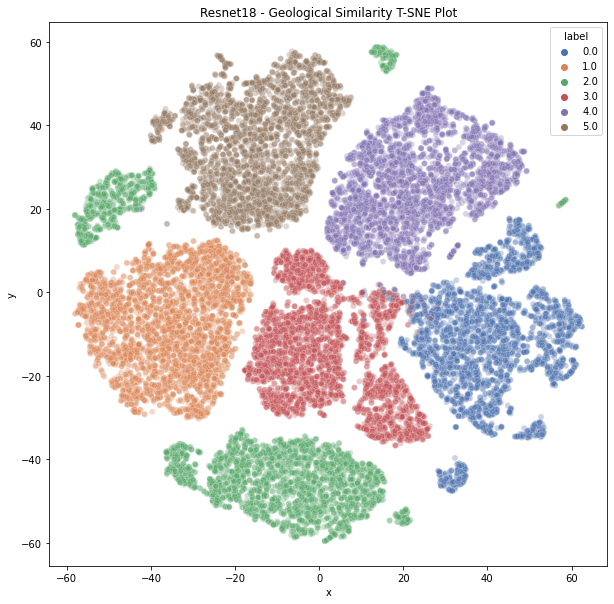

In [45]:
plt.figure(figsize=(10,10))

df = pd.DataFrame(np.hstack([tsne_train_memory, train_labels]), columns=['x', 'y', 'label'])
plt.title('Resnet18 - Geological Similarity T-SNE Plot')
sns.scatterplot(
    x='x', y='y',
    hue='label',
    data=df,
    palette="deep",
    legend="full",
    alpha=0.3
)

Awesome! Looks like our model learned something. Even though we didn't actually use our validation dataset to perform model selection (we're using the last model checkpoint, so it could just have easily been overfitted), we still produce robust features according to this plot. There are some disparite clusters, but it's hard to tell if thats from a poor perplexity setting or the feature extractor itself.

# Perform kNN retrieval

For each sample in the validation set, we're going to go and perform the kNN retrieval for it. For now, we're going to set K=20, and evaluate accuracy@1, accuracy@5. We could also perform a majority vote, but I'll skip that for now. For obvious reasons, we will measure the distance using Cosine distance. Alternatively, we could l2 normalize then take the euclidean distance. Regardless, we don't want the magnitude of the vectors to contribute to the distance between them. 

In [66]:
K = 20
distances = cosine_distances(val_features, train_memory)
train_indices_sorted_by_distance = np.argsort(distances, axis=1)[:, :K]

In [155]:
retrieved_labels = train_labels[train_indices_sorted_by_distance]
retrieved_file_paths = np.array(train_files)[train_indices_sorted_by_distance]

Now, lets write a function to compute the topK accuracy

In [139]:
def accuracy_at_k(pred_labels, val_labels, k=1):
    correct = 0.0
    for i in np.unique(val_labels):
        mask = val_labels.flatten() == i
        retrievals = retrieved_labels[mask][:, :k]
        correct += np.any(retrievals == i, axis=1).sum()
    return correct / len(val_labels)

In [140]:
print(f'Accuracy@1: {accuracy_at_k(retrieved_labels, val_labels, k=1):2f}')
print(f'Accuracy@5: {accuracy_at_k(retrieved_labels, val_labels, k=5):2f}')

Accuracy@1: 0.989667
Accuracy@5: 0.993667


# Display the K-Nearest Neighbors for a given sample

Lets randomly choose a sample from the dataset and display the K-Nearest Neighbors. For the sanity of plotting, we'll set K = 5.

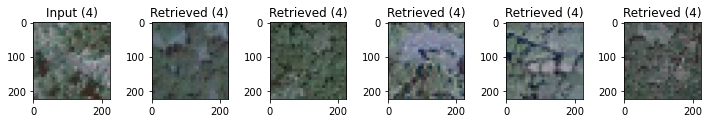

In [174]:
K = 5
idx = np.random.choice(len(val_labels), 1)[0]
to_show = [val_files[idx]] + retrieved_file_paths[idx][:K].flatten().tolist() 
subtitles = [val_labels[idx][0]] + retrieved_labels[idx][:K].flatten().tolist()

fig, axs = plt.subplots(1, K+1, figsize=(10, 10))
plt.tight_layout()
for i, (file_path, label) in enumerate(zip(to_show, subtitles)):
    img = rasterio.open(file_path).read(out_shape=(3, 224, 224)).transpose(1, 2, 0)
    axs[i].imshow(img)
    if i == 0:
        axs[i].set_title(f'Input ({label})')
    else:
        axs[i].set_title(f'Retrieved ({label})')

# Conclusion

* Data: 80/20 split (for simplicity)
* Model: Resnet18 (small, fast, but still robust)
* Validation Results: 99.1345% accuracy
* kNN on validation results (without model selection)
   * Acc@1 = 98.9667%
   * Acc@5 = 99.3667%

### Future Directions

1. I would really like to construct a more robust feature extractor for this to improve kNN retrieval results, particularly through the use of 
self-supervised training. Noise Contrastive Estimation approaches like UFL and Mocov1/2/3, while computationally expensive,
are really easy to drop in any backbone and train to performance. They have proven that self-supervised pretraining
leads to more robust features and often more separable feature spaces. Of course, I could get fancier and try newer approaches
like SWAV/BYOL, DINO or MAE, but those models are complex. If I had an additional day, I would absolutely throw a self-supervised
training regime at this to see how that effected the embedding space. That being said, performance is already really saturated
so I doubt there'd be a quantifiable difference in performance.